[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_2_Autoencoder_in_fMRI_continue.ipynb)

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score


from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 0s (9,063 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...


Using TensorFlow backend.


# Read condition

## Experiment:

### Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

In [0]:
from IPython.display import Image
image_id = 'https://drive.google.com/open?id=1qZfXGiqtQ9g5DJsCtb_Injy_tSCEJ3dG'.split('id=')[-1]
image = drive.CreateFile({'id':image_id})
image.GetContentFile('{}'.format('words.png'))


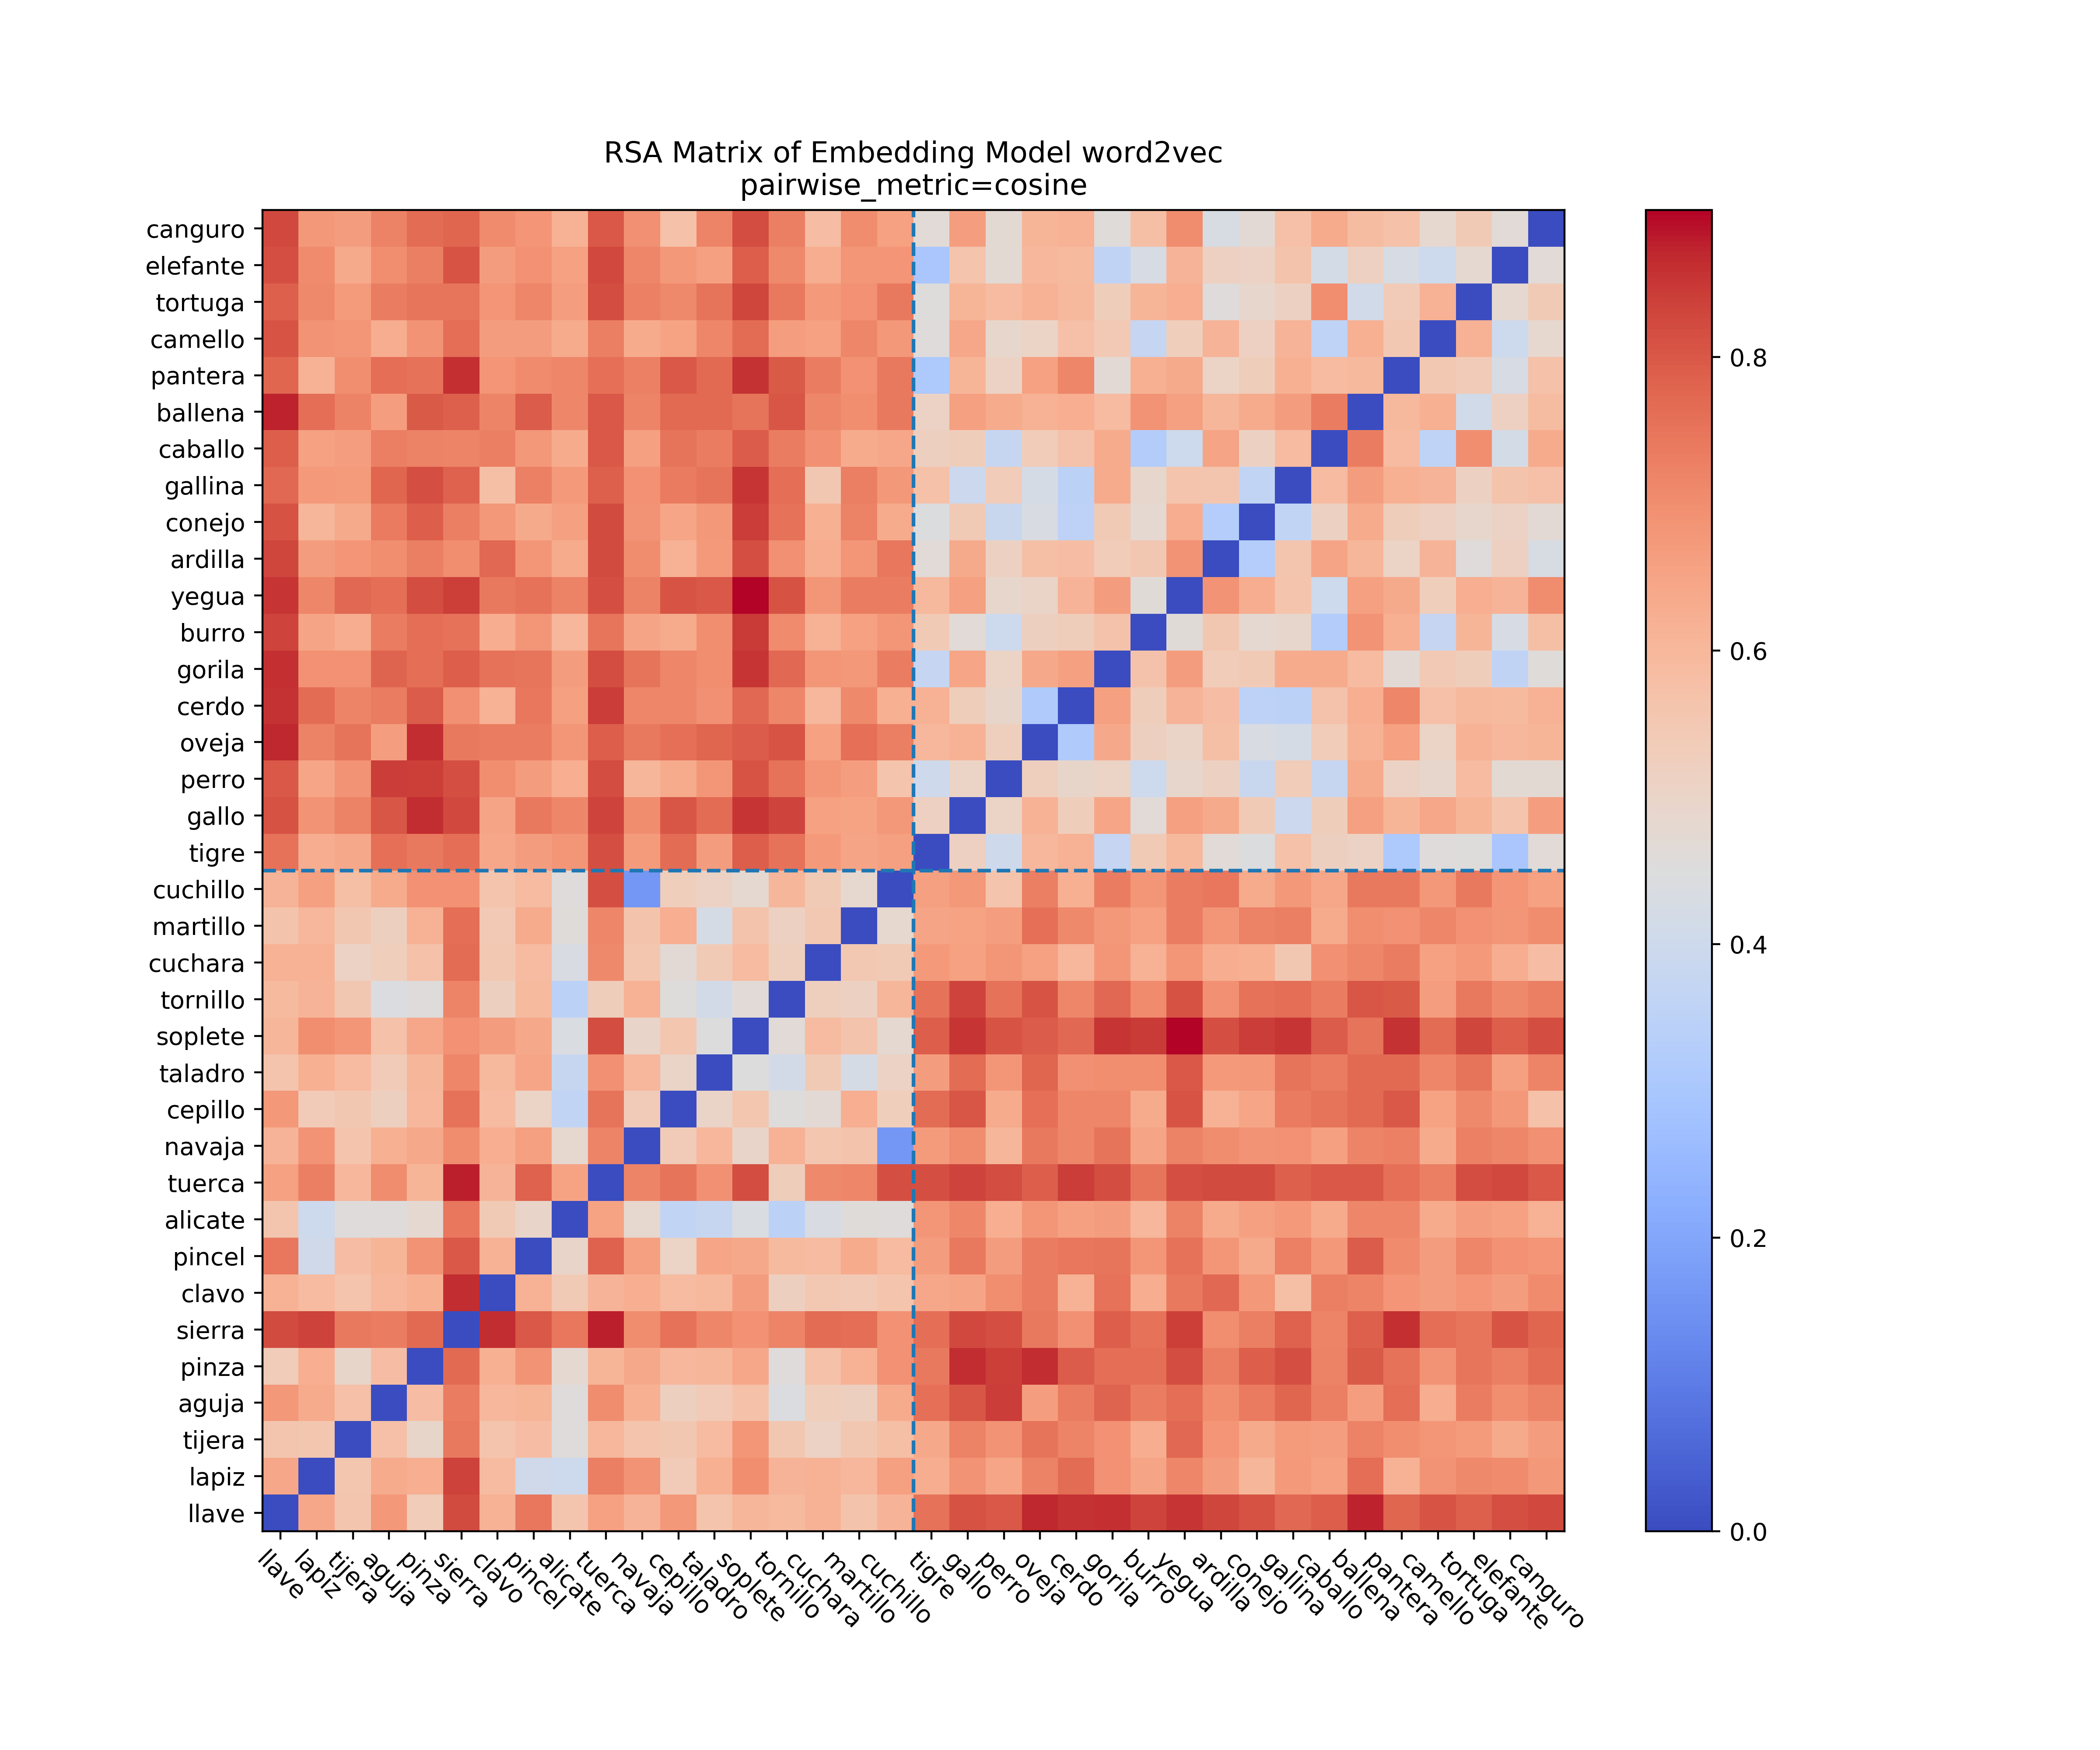

In [3]:
Image('words.png',height=800)

In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [5]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

In [0]:
import keras
from keras.layers                                  import Conv3D,Dense,Dropout,BatchNormalization
from keras.layers                                  import Input, AveragePooling3D,MaxPooling3D,Conv2DTranspose
from keras.layers                                  import Flatten,LeakyReLU,UpSampling3D,ThresholdedReLU
from keras.layers                                  import GlobalAveragePooling3D,Permute,GlobalMaxPool2D
from keras.layers                                  import Conv2D,GlobalAveragePooling2D,UpSampling2D
from keras.layers                                  import AveragePooling2D,MaxPool2D,merge
from keras.layers                                  import GaussianNoise,GaussianDropout
#from keras.layers import ReLU
from keras.models                                  import Model,Sequential
from keras.layers.noise                            import GaussianNoise,AlphaDropout
from keras.callbacks                               import ModelCheckpoint,TensorBoard,EarlyStopping
from keras                                         import backend as K
from keras                                         import regularizers
from keras.layers                                  import Reshape
from keras.layers                                  import Conv3DTranspose,Activation, Lambda,Multiply
from keras.layers                                  import Layer
from keras.losses                                  import mse





In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          =monitor,# saving criterion
                                 save_best_only   =True,# save only the best model
                                 mode             =mode,# saving criterion
                                 period           =frequency,# frequency of check the update 
                                 verbose          =verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          =monitor,
                                 min_delta        =min_delta,
                                 patience         =patience,
                                 verbose          =verbose, 
                                 mode             =mode,
                                 )
    return [checkPoint,earlyStop]

# loss of VAE = recontruction loss + $\beta$ * KL divergence loss of the sampling layer, $\beta = 1$
# $$\text{KL divergence loss of the sampling layer} = - 0.5 * \sum(1 + log(\sigma) - \mu^2 - exp(log(\sigma)))$$
# where $\mu$ and $\sigma$ are learned from the input data
# To sample data from a Gaussian distribution that controlled by the $\mu$ and $\sigma$ learned from the inputs, we add a noise term $\epsilon$ to the distribution and sample from the distribution
# $$samples = tahn(\mu + exp[0.5 * log(\sigma)] * \epsilon)$$
# why use tahn? It is because we want the sampled outputs restricted between -1 and 1 for later if we want to visualize the learned representations of the latent layer
# of course you can use sigmoid function to constraint the value between 0 and 1, which seems to be easier and more intuitive.

In [0]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self,reg = 'vae', beta = 100, capacity = 0,*args, **kwargs):
        self.is_placeholder = True
        self.reg = reg
        self.beta = beta
        self.capacity = capacity
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        if self.reg == 'bvae':
            mu,log_var = inputs
            
            kl_batch            = - .5 * K.sum(1 + log_var -
                                               K.square(mu) -
                                               K.exp(log_var), axis=-1)
            kl_batch            = self.beta * K.abs(kl_batch - self.capacity/K.int_shape(mu)[1])
            
            self.add_loss(K.mean(kl_batch),inputs=inputs)
            return inputs
        else:
            mu, log_var         = inputs
    
            kl_batch            = - .5 * K.sum(1 + log_var -
                                               K.square(mu) -
                                               K.exp(log_var), axis=-1)
    
            self.add_loss(K.mean(kl_batch), inputs=inputs)
    
            return inputs
    


In [0]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch             = K.shape(z_mean)[0]
    dim               = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon           = K.random_normal(stddev=0.5,shape=(batch, dim))
    return K.tanh( z_mean + K.exp(0.5 * z_log_var) * epsilon)#mu + sigma * eps

In [0]:
from keras.regularizers import Regularizer

In [0]:
class SparseActivityRegularizer(Regularizer):
    def __init__(self, sparse_beta = 1, rho = 0.02,epsilon = 1e-7):
        self.sparse_beta = sparse_beta
        self.rho = rho
        self.epsilon = epsilon
        
    def __call__(self,x):
        regularization = 0.
        rho = self.rho
        beta = self.sparse_beta
        #return 100000*K.shape(activ_matrix) # usefule for debug
        # axis 0 size is batch_size
        # axis 1 size is layer_size
        rho_bar = K.mean(x) + self.epsilon # average over the batch samples
        KLs = rho * K.log(rho / rho_bar) + (1 - rho) * K.log((1 - rho) / (1 - rho_bar))
        regularization += KLs
        return regularization
    
    def get_config(self):
        return {'sparse_beta':self.sparse_beta,
                'rho': self.rho,
                }

In [0]:
class stacked_perceptron(object):
    
    def __init__(self,
#                 inputs,
                 hidden_units,
                 beta                                       = 1,
                 lamda                                      = 1,
                 dropout_func                               = AlphaDropout,
                 dropout_rate                               = 0.2,
                 name                                       = [1,1,'encode'],
                 kernel_regularizer                         = regularizers.l1_l2,
                 kernel_initializer                         ='he_normal',
                 activation                                 = 'selu',
                 alpha = 0.3,
                 l1                                         = False,
                 use_bias                                   = True,
                 ):
#        self.inputs = inputs
        self.hidden_units                                   = hidden_units
        self.kernel_regularizer                             = kernel_regularizer
        self.kernel_initializer                             = kernel_initializer
        self.beta                                           = beta
        self.lamda                                          = lamda
        self.dropout_func                                   = dropout_func
        self.dropout_rate                                   = dropout_rate
        self.name                                           = name
        self.activation                                     = activation
        self.alpha                                          = alpha
        self.l1                                             = l1
        self.use_bias                                       = use_bias
    def __call__(self,net):
        if self.l1: # if regularize the nonlinear output
            net = Dense(units                               = self.hidden_units,
                        use_bias                            = self.use_bias,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
                        activity_regularizer                = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        else:
            net = Dense(units                               = self.hidden_units,
                        use_bias                            = True,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
#                        activity_regularizer = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        net = BatchNormalization(name                       = 'norm_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+1,
                                                                                          self.name[2]))(net)
        if type(self.activation) is not str:
            net = self.activation(name                      = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                                  alpha                     = self.alpha)(net)
        else:
            net = Activation(activation = self.activation,
                             name                           = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                              )(net)
        net = self.dropout_func(rate                        = self.dropout_rate,
                      name                                  = 'drop_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+3,
                                                                                          self.name[2]))(net)
        
        return net

In [0]:
def betaVariationAutoencoder(shape,
                             hidden_units                       = [2], # list of hidden units
                             dropout_rate                       = 0.2,# drop out rate
                             latent_dim                         =100, # dimensions/number of neurons in the latent layers (z_mean, z_log_var, and z)
                             beta                               =1, # control for the sparsity of the activation function
                             sparse_beta                        =5, # no used
                             rho                                =0.02, # not used
                             lamda                              =1,# control for sparsity of the parameters (aka making the model simpler)
                             lr                                 =1e-4, # learning rate
                             decay                              =1e-9,# scheduled decrease of the learning rate
                             reg                                ='bvae', # always use bvae even if beta is 1
                             BETA                               =100, # control for learned distanglement
                             capacity                           =50, # control for the distanglement of the hidden units
                            ): 
    """
    Beta Variational Autoencoder
    
    Beta is to control for the representation learning
    
    """
    # input layer
    inputs            = Input(shape                                        = (shape,),
                              batch_shape                                  = (None,shape),
                              name                                         = 'inputs',
                              dtype                                        = 'float32'
                              )
    # end of the input layer
    # adding Gaussian noise to the input data
    GaussianNoise(stddev = .5)(inputs)
    # end of adding Gaussian noise to the input data
    ############# construct the encoding layers with a for-loop ######################
    encode_           = inputs
    for ii,hidden_unit in enumerate(hidden_units):# for each encoding layer:
        encode_       = stacked_perceptron(hidden_unit, # specify the number of neurons
                                           beta                            = beta, # control for the sparsity of the activation function
                                           lamda                           = lamda, # control for the sparsity of the parameter values
                                           dropout_rate                    = dropout_rate, # drop out rate
                                           name                            = [ii+1,1,'en'], # name the layers
                                           use_bias                        = True,# biases set to 1
                                           )(encode_)
    # end of contructing the encoding layers ##########################################
    # the encoding model can be used as a feature extractor
    feature_extractor = Model(inputs,encode_,'feature_extractor')
    ################ the 2 outputs of the encoding layers: z_mean and z_log_var
    ################ and the values used for reconstructing the inputs are sampled
    ################ from the Gaussian distribution controlled by them
    ################ and these 2 modules are learnable via the encoding layers
    # latent space
    z_mean            = stacked_perceptron(latent_dim,
                                           beta                            = beta,
                                           lamda                           = lamda,
                                           dropout_rate                    = dropout_rate,
                                           name                            = ['_z_mean',1,'en'],
                                           l1                              = True,
                                           use_bias                        = True,
                                           )(encode_)
    z_log_var         = stacked_perceptron(latent_dim,
                                           beta                            = beta,
                                           lamda                           = lamda,
                                           dropout_rate                    = dropout_rate,
                                           name                            = ['_z_log_var',1,'en'],
                                           use_bias                        = True,
                                           l1                              = True,
                                           )(encode_)
    # connect these 2 modules to the encoding layers and add the KL divergence loss to the model total losses
    z_mean,z_log_var = KLDivergenceLayer(reg                               = reg,
                                         beta                              = BETA,
                                         capacity                          = capacity,
                                         )([z_mean,z_log_var])
    # sample z values from the Gaussian distribution ~ (z_mean, z_log_var)
    z                = Lambda(sampling,
                              output_shape                                 = (latent_dim,),
                              name                                         = 'z',
                              )([z_mean,z_log_var])
    # noted that the encoder is different from the encoding layers
    # it contains the sampling part
    # the encoder contains 3 outputs: z_mean, z_log_var, z
    # and they are not independent
    encoder          = Model(inputs,[z_mean,z_log_var,z],name              ='encoder')
    
    # constructing the decoding layers with a for-loop
    latent_inputs    = Input(shape                                         = (latent_dim,),
                             name                                          = 'z_sampleing')
    decode_          = latent_inputs
    hidden_units_    = hidden_units
    hidden_units_.reverse() # inverse the order of the hidden units of the encoder, which means, the decoder is a symmetric construct of the encoder
    for ii,hidden_unit in enumerate(hidden_units_):
        decode_      = stacked_perceptron(hidden_unit,
                                          beta                             = beta,
                                          lamda                            = lamda,
                                          dropout_rate                     = dropout_rate,
                                          name                             = [ii+1,1,'de'],
                                          use_bias                         = True,
                                          )(decode_)
    # end of constructing the decoding layers with a for-loop
    # connect the decoding layers to a output layer, which is the reconstructed input vlaues
    outputs          = Dense(units                                         = shape,
                             use_bias                                      = True,
                             name                                          ='outputs',
                             kernel_initializer                            = 'he_normal',
                             kernel_regularizer                            = regularizers.l1_l2(1e-6,lamda),
                             activity_regularizer                          = regularizers.l1(0.01),# very sparse activation function
                             activation                                    = 'sigmoid',# output value between 0 and 1
                             )(decode_)
    decoder          = Model(latent_inputs,outputs,name                    ='decoder')
    outputs          = decoder(encoder(inputs)[2])# functionalize the decoder
    autoencoder      = Model(inputs,outputs,name                           = 'vae')
    autoencoder.compile(optimizer                                          = keras.optimizers.Adam(lr    =lr,
                                                                                                   decay =decay),
                        loss                                               = keras.losses.binary_crossentropy,
                        metrics                                            = [keras.metrics.cosine_proximity])
        
    return feature_extractor,encoder,decoder,autoencoder

In [0]:
scaler           = MinMaxScaler() # scale the data between 0 and 1, and this is why we use sigmoid function as the activation function for last layer of the VAE
shape            = dataset.shape[1] # get the size of the data for the autoencoder
vae_model_name   = 'test.beta.vae.%s.%s.%s.hdf5'%('read','combined','full') # temporal model name for saving the weights
batch_size       = 16

In [0]:
callBackList = make_CallBackList(vae_model_name,
                               monitor                      ='val_loss', # metric I care
                               mode                         ='min', # how I care
                               verbose                      =0,# print out the process
                               min_delta                    =1e-3,# how much difference it should make
                               patience                     =50, # early stop argument
                               frequency                    =1
                               )

In [0]:
feature_extractor,encoder,decoder,autoencoder= betaVariationAutoencoder(
  shape, # input shape
  hidden_units      =[512,128], # layers and units in each layers
  dropout_rate      =0.4, # drop out rate for each hidden layer
  beta              =1e-5, # for activation sparsity
  lamda             =0.005, # for model simplicity
  lr                =1e-3, # learning rate
  decay             =1e-6, # schedule decay of the learning rate 
  latent_dim        =72, # latent space dimensionality 
  BETA              =50,
  capacity          =36, # = 36 words, I want only 36 of them matters the most (a big assumption explicitly encoded in the VAE model)
                                          )

In [21]:
print(encoder.summary(),decoder.summary(),autoencoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 16130)        0                                            
__________________________________________________________________________________________________
dense_layer1_1_en (Dense)       (None, 512)          8259072     inputs[0][0]                     
__________________________________________________________________________________________________
norm_layer1_2_en (BatchNormaliz (None, 512)          2048        dense_layer1_1_en[0][0]          
__________________________________________________________________________________________________
activation_layer1_3_en (Activat (None, 512)          0           norm_layer1_2_en[0][0]           
__________________________________________________________________________________________________
drop_layer

# This is one of good practices when working with deep neural network: passing zeros through the model and knows the initialized losses of the model
# the first result is the initial loss, which is the reconstruction loss + KL loss of the model. Since the input values are all zeros, the loss represents the total weights
# the second result is the initial similarity between the inputs and the reconstructed inputs. Here, 0 means a good initialization because it means no positive or negative correlations

In [22]:
print('initial loss {:.4f}'.format(autoencoder.evaluate(np.zeros(dataset.shape),np.zeros(dataset.shape),
                                                                batch_size = batch_size,
                                                                verbose     = 0
                                                                )[0]
                                            )
            )
print('initial metrics {:.4f}'.format(autoencoder.evaluate(np.zeros(dataset.shape),np.zeros(dataset.shape),
                                                                batch_size = batch_size,
                                                                verbose     = 0
                                                                )[1]
                                            )
            )

initial loss 1423.2430
initial metrics 0.0000


# I am going to cheat a little bit by training the VAE with all the data instead of re-initialize it and train it with each fold of the cross validation
# I am still going to use a cross validation to train the VAE, but it serves a different purpose than the common cross-validation loop


In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
print_train = 0
epochs      = 3000
label_map = {'animal':[0,1],
             'tool':[1,0]}
data            = dataset.samples.astype('float32')
data            = scaler.fit_transform(data)
ids             = dataset.sa.id.astype(int)
chunks          = dataset.sa.chunks
labels          = np.array([label_map[item] for item in dataset.targets])[:,-1]
sample_indecies = np.arange(len(labels))
blocks          = [np.array([ids[ids    == target],
                    chunks[ids          == target], 
                    labels[ids          == target],
                    sample_indecies[ids == target]
                    ]) for target in np.unique(ids)]
block_labels    = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
cv = StratifiedShuffleSplit(n_splits=100,test_size=0.15,random_state=12345)
for z,(training,validation) in enumerate(cv.split(blocks,block_labels)):
    idx_training    = np.concatenate([blocks[tr_el][-1] for tr_el in training])
    idx_validation  = np.concatenate([blocks[te_el][-1] for te_el in validation])
    if z > 3: 
        pass
    else:
        print('autoencoder loss starts with {:.4f}'.format(autoencoder.evaluate(
                                              data,
                                              data,
                                              batch_size                    = batch_size,
                                              verbose                       = 0
                                                                      )[0]))
        # fit the autoencoder with train data, and validate with validation data
        # remember the callbacks? That is why we need validation data
        # if the validation loss goes down, we save the model weights for that moment
        # if the validation loss don't go down for a couple epochs, we stop training
        history                 = autoencoder.fit(  
                                    data[idx_training],data[idx_training],# input, output
                                    batch_size                              = batch_size,# min batch size
                                    epochs                                  = epochs,# just lots of epochs
                                    validation_data                         = (data[idx_validation],data[idx_validation]),# split the last 10% of the data as the validation data
                                    verbose                                 = print_train,# print out the process
                                    callbacks                               = callBackList # call back functions
                                    )
        autoencoder.load_weights(vae_model_name) # load the saved best model weights
        # let's look at the current model loss with all the training + validation data combined
        training_loss = autoencoder.evaluate(data,data,
                                             batch_size                     = batch_size,
                                             verbose                        = 0
                                             )
        print('autoencoder loss = {:.4f},consine = {:.4f}'.format(training_loss[0],training_loss[1]))

autoencoder loss starts with 4333.9345
autoencoder loss = 729.1628,consine = -0.9551
autoencoder loss starts with 729.1614
autoencoder loss = 729.1623,consine = -0.9551
autoencoder loss starts with 729.1643
autoencoder loss = 729.1621,consine = -0.9551
autoencoder loss starts with 729.1631
autoencoder loss = 729.1657,consine = -0.9551


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import (classification_report,
                           matthews_corrcoef,
                           confusion_matrix,
                           f1_score,
                           log_loss)
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold         = roc_curve(target, predicted)
    i                           = np.arange(len(tpr)) 
    roc                         = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t                       = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
scores = []
cfm    = []
cv     = StratifiedShuffleSplit(n_splits=30,test_size=0.15,random_state=12345)
for fold,(train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_el][-1] for tr_el in train])
    idx_test  = np.concatenate([blocks[te_el][-1] for te_el in test])
    
    autoencoder.load_weights(vae_model_name) # load the saved best model weights
    # with the autoencoder + SVC
    # select and average the training and test data again for sure
    tr             = dataset[idx_train].get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))# select the training set
    te             = dataset[idx_test].get_mapped( mean_group_sample(['chunks', 'trials'],order = 'occurrence'))# select the test set
    # scale the training data to between 0 and 1
    scaler         = MinMaxScaler()
    X_train        = scaler.fit_transform(tr.samples.astype('float32'))
    y_train        = np.array([label_map[item] for item in tr.sa.targets])[:,-1]
    X_train        = feature_extractor.predict(X_train,
                                              batch_size = batch_size,
                                              verbose    = 0)#[2]
    # scale the test data with the scaler trained by the training data
    X_test         = scaler.transform(te.samples.astype('float32'))
    y_test         = np.array([label_map[item] for item in te.sa.targets])[:,-1]
    X_test         = feature_extractor.predict(X_test,
                                               batch_size = batch_size,
                                               verbose    = 0)#[2]
    
    clf            = RandomForestClassifier(n_estimators = 100,
                                            #max_depth = 3,
                                            random_state = 12345)
    clf.fit(X_train,y_train)
    preds          = clf.predict_proba(X_test)[:,-1]
    score1         = roc_auc_score(y_test,preds,)
    threshold_     = Find_Optimal_Cutoff(y_test,preds)[0]
    score2         = matthews_corrcoef(y_test,preds>threshold_)
    score3         = f1_score(y_test,preds>threshold_)
    score4         = log_loss(y_test,preds,)
    tn, fp, fn, tp = confusion_matrix(y_test,preds>threshold_).ravel()
    print(classification_report(y_test,preds>threshold_))
    scores.append([score1,score2,score3,score4])
    cfm.append([tn, fp, fn, tp])

             precision    recall  f1-score   support

          0       0.52      0.58      0.55        19
          1       0.53      0.47      0.50        19

avg / total       0.53      0.53      0.53        38

             precision    recall  f1-score   support

          0       0.52      0.58      0.55        19
          1       0.53      0.47      0.50        19

avg / total       0.53      0.53      0.53        38

             precision    recall  f1-score   support

          0       0.55      0.58      0.56        19
          1       0.56      0.53      0.54        19

avg / total       0.55      0.55      0.55        38

             precision    recall  f1-score   support

          0       0.50      0.58      0.54        19
          1       0.50      0.42      0.46        19

avg / total       0.50      0.50      0.50        38

             precision    recall  f1-score   support

          0       0.45      0.53      0.49        19
          1       0.44      0.37 

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [94]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.548 +/- 0.083
f1 score = 0.512 +/- 0.077


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Baseline Model')]

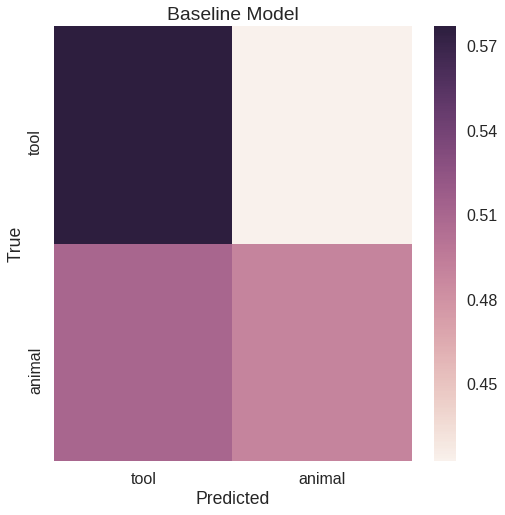

In [96]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Baseline Model')

# using the full encoder (with the Gaussian sampling layer) to get extra data from the inputs

In [0]:
df_gen = []
n = 1;np.random.seed(12345)
ids             = np.concatenate([dataset.sa.id.astype(int) for _ in range(n)])
chunks          = np.concatenate([dataset.sa.chunks for _ in range(n)])
labels          = np.concatenate([np.array([label_map[item] for item in dataset.targets])[:,-1] for _ in range(n)])
sample_indecies = np.concatenate([np.arange(dataset.shape[0]) for _ in range(n)])


In [0]:
blocks          = [np.array([ids[ids    == target],
                    chunks[ids          == target], 
                    labels[ids          == target],
                    sample_indecies[ids == target]
                    ]) for target in np.unique(ids)]
block_labels    = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()

for _ in range(n):
    mu_animal,sigma_animal,z_animal = encoder.predict(data[dataset.sa.targets == 'animal'])
    mu_tool, sigma_tool,z_tool      = encoder.predict(data[dataset.sa.targets == 'tool'])
    df_animal = pd.DataFrame(z_animal,columns=['%d'%(d+1) for d in range(72)])
    df_animal['labels'] = 'animal'
    df_tool = pd.DataFrame(z_tool,columns=['%d'%(d+1) for d in range(72)])
    df_tool['labels'] = 'tool'
    df_gen.append(df_animal)
    df_gen.append(df_tool)
df_gen = pd.concat(df_gen)

In [0]:
df_animal = df_gen[df_gen['labels'] == 'animal']
df_tool   = df_gen[df_gen['labels'] == 'tool'  ]

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
X = df_gen.iloc[:,:-1].values
y = df_gen['labels'].values
y = np.array([label_map[item] for item in y])[:,-1]
scores = []
cfm    = []
cv     = StratifiedShuffleSplit(n_splits=30,test_size=0.15,random_state=12345)
for fold,(train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_el][-1] for tr_el in train])
    idx_test  = np.concatenate([blocks[te_el][-1] for te_el in test])
    
    X_train = X[idx_train]
    y_train = y[idx_train]
    
    X_test  = X[idx_test]
    y_test  = y[idx_test]
    
    clf            = RandomForestClassifier(n_estimators = 100,
                                            #max_depth = 3,
                                            random_state = 12345)
    print('fitting')
    clf.fit(X_train,y_train)
    print('predicting')
    preds          = clf.predict_proba(X_test)[:,-1]
    score1         = roc_auc_score(y_test,preds)
    threshold_     = Find_Optimal_Cutoff(y_test,preds)[0]
    score2         = matthews_corrcoef(y_test,preds>threshold_)
    score3         = f1_score(y_test,preds>threshold_)
    score4         = log_loss(y_test,preds,)
    tn, fp, fn, tp = confusion_matrix(y_test,preds>threshold_).ravel()
    print(classification_report(y_test,preds>threshold_))
    scores.append([score1,score2,score3,score4])
    cfm.append([tn, fp, fn, tp])

fitting
predicting
             precision    recall  f1-score   support

          0       0.57      0.55      0.56       134
          1       0.43      0.45      0.44       101

avg / total       0.51      0.51      0.51       235

fitting
predicting
             precision    recall  f1-score   support

          0       0.52      0.62      0.57       111
          1       0.59      0.49      0.54       124

avg / total       0.56      0.55      0.55       235

fitting
predicting
             precision    recall  f1-score   support

          0       0.40      0.51      0.44        99
          1       0.53      0.42      0.47       132

avg / total       0.47      0.46      0.46       231

fitting
predicting
             precision    recall  f1-score   support

          0       0.53      0.55      0.54       128
          1       0.43      0.42      0.43       105

avg / total       0.49      0.49      0.49       233

fitting
predicting
             precision    recall  f1-score   

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [116]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.523 +/- 0.034
f1 score = 0.477 +/- 0.055


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Baseline Model')]

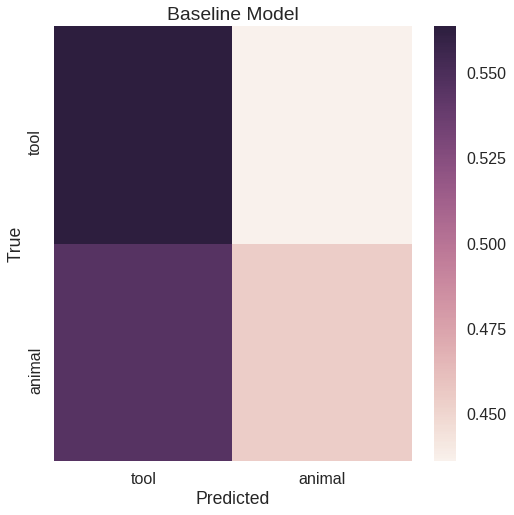

In [118]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Baseline Model')

In [0]:
sampled_z = encoder.predict(MinMaxScaler().fit_transform(dataset.samples.astype('float32')))[2]
labels    = np.array([label_map[item] for item in dataset.sa.targets])[:,-1]

In [125]:
sampled_z.shape,labels.shape

((1544, 72), (1544,))

In [134]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
list(df)[1:]

['var1', 'var2', 'var3', 'var4', 'var5']

In [0]:
from matplotlib import pyplot as plt
from math import pi

In [0]:
N = 72
angles = [n / float(N) * 2. * pi for n in range(N)]
angles += angles[:1]


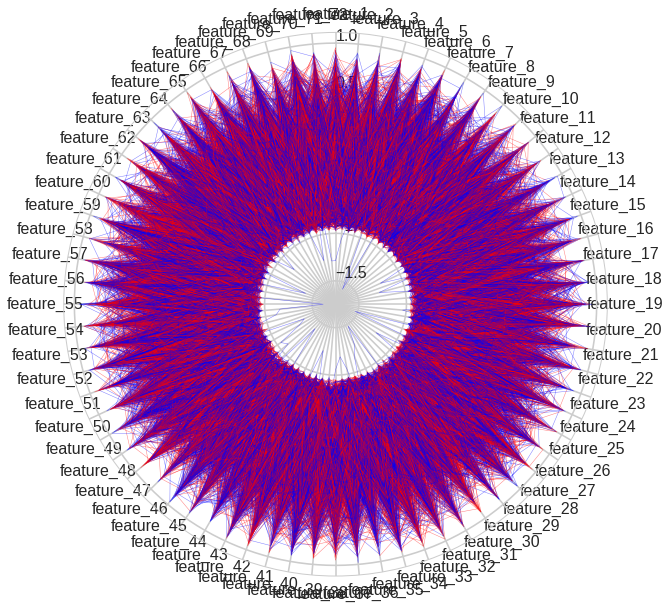

In [144]:
color = ['red','blue']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,polar = True)
_=ax.set_theta_offset(pi / 2)
_=ax.set_theta_direction(-1)

_=ax.set(xticks = angles[:-1],xticklabels=['feature_{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(sampled_z,labels):
    values = list(row)
    values += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.5,color=color[label])